In [ ]:
#%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

from sklearn import datasets as data
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import hdbscan

# Cấu hình để ẩn log của Optuna trong quá trình tối ưu hóa
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Bỏ qua các cảnh báo về việc không thể tính score khi chỉ có 1 cụm
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 120, 'linewidths':0}

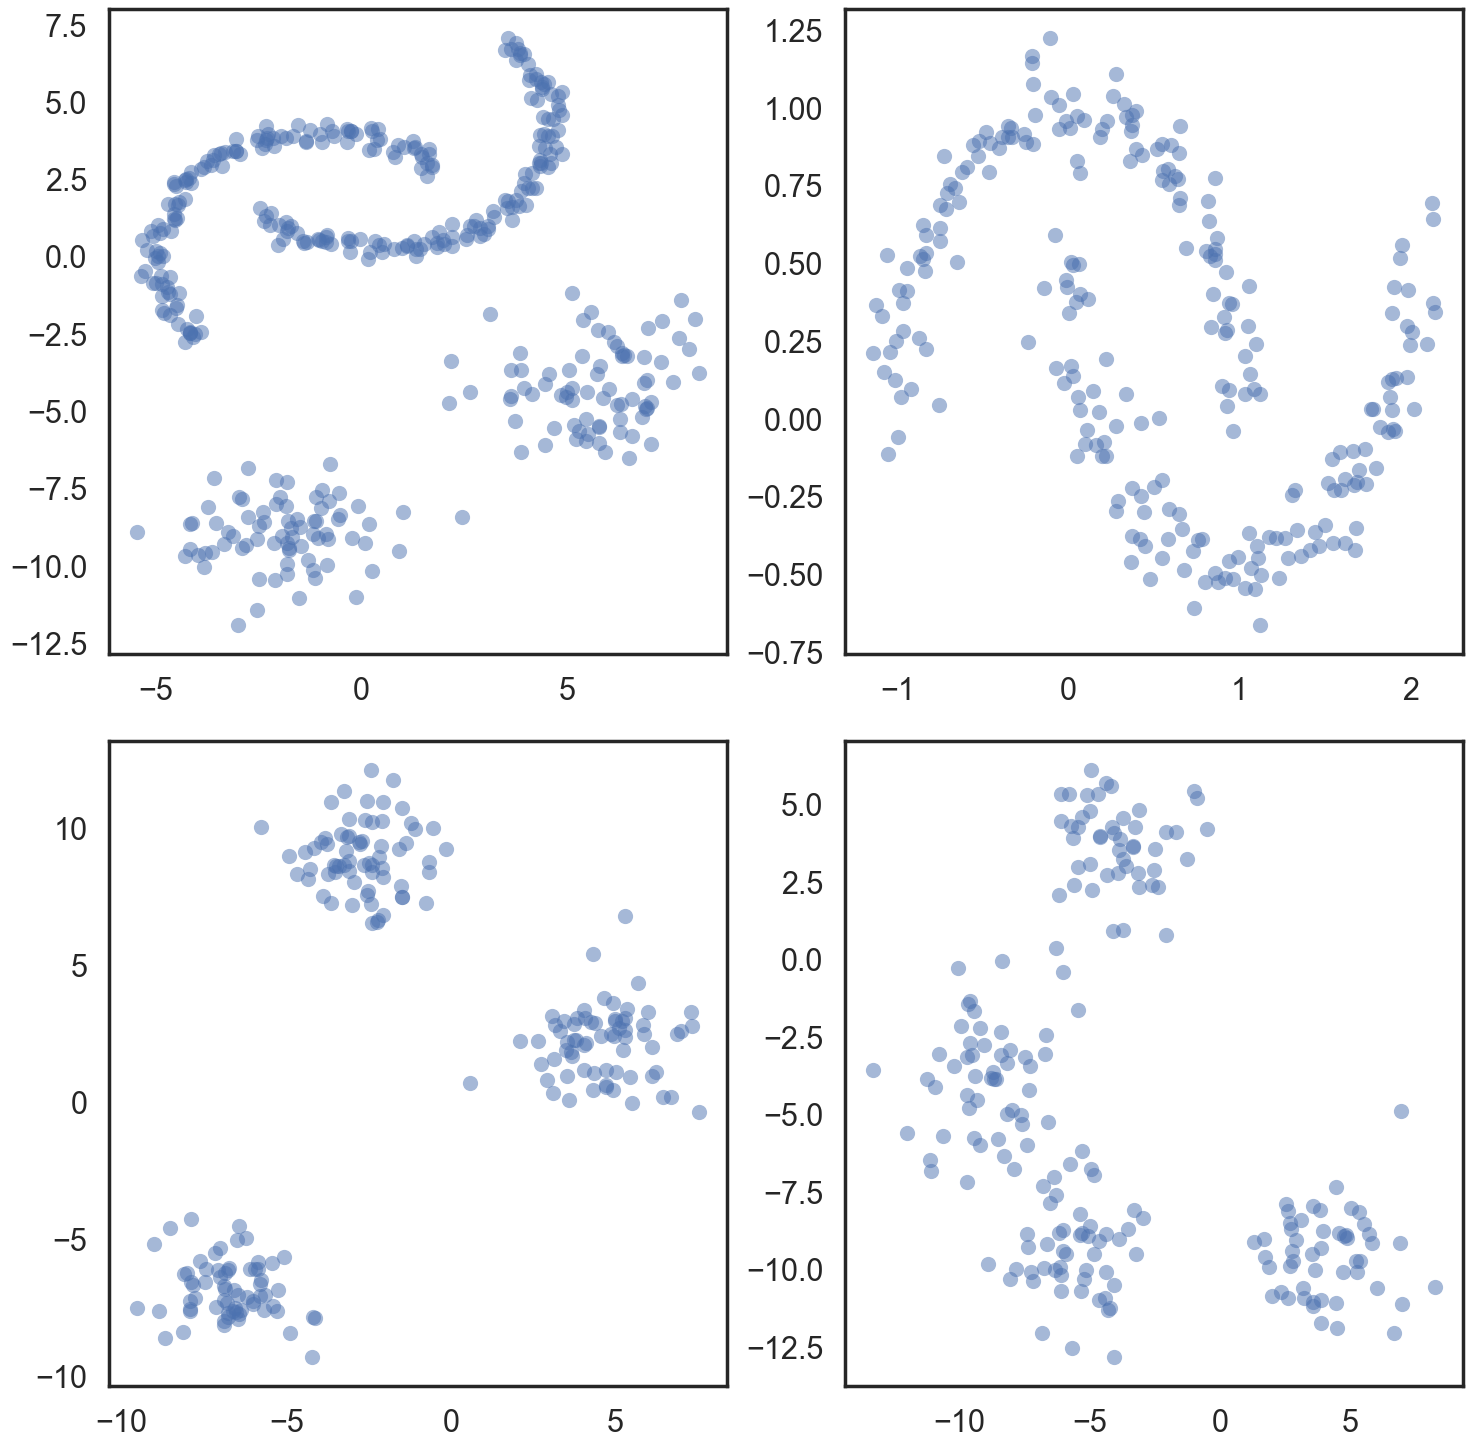

In [3]:
moons_1, _ = data.make_moons(n_samples=250, noise=0.045, random_state= 42)
blobs_1, _ = data.make_blobs(n_samples=150, cluster_std=1.25, random_state=40, centers = 2)
scale = 4.0 # phóng to
theta = 0.75 # góc xoay (radians), để 0 nếu không muốn xoay
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
moons_transformed = moons_1.dot(R.T) * scale + np.array([-1.0, 0.0])  # dịch sang trái 3 đơn vị
test_data = np.vstack([moons_transformed, blobs_1])

moons_2, _ = data.make_moons(n_samples=100, noise=0.05, random_state= 42)
moons_3, _ = data.make_moons(n_samples=150, noise=0.105, random_state= 42)
test_data2 = np.vstack([moons_2, moons_3])

# Case 2
blobs_2, _ = data.make_blobs(n_samples=200, cluster_std=1.25, random_state=42, centers = 3)

# Case 3
blobs_3, _ = data.make_blobs(n_samples=200, cluster_std=1.5, random_state=21, centers = 4)


fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]
ax1.scatter(test_data[:, 0], test_data[:, 1], color='b', **plot_kwds)
ax2.scatter(test_data2[:, 0], test_data2[:, 1], color='b', **plot_kwds)
ax3.scatter(blobs_2.T[0], blobs_2.T[1], color='b', **plot_kwds)
ax4.scatter(blobs_3.T[0], blobs_3.T[1], color='b', **plot_kwds)
plt.tight_layout()
plt.show()

In [4]:
"""Vì so sánh công bằng không phải là thực hiện chạy thuật toán trên cùng một bộ tham số,
mà là chạy từng thuật toán trên bộ tham số tốt nhất của chúng. Do đó, ta thực hiện
tối ưu hóa từng mô hình rồi so sánh.

Chỉ số so sánh:
DBCV - Silhouette score

Mô hình so sánh:
Khác hướng tiếp cận: K-Means (phân cụm phân hoạch), HAC (phân cụm phân cấp)
Cùng hướng tiếp cận (phân cụm mật độ): DBSCAN, Mean Shift"""

# Vì Silhouette score không thích hợp để đánh giá các cụm "không lồi", nên kết hợp cả dbcv
def calculate_scores(X, labels):
    """Hàm phụ để tính cả hai score và xử lý các trường hợp lỗi."""
    unique_labels = np.unique(labels)
    
    # Bỏ qua điểm nhiễu (-1)
    core_samples_mask = labels != -1
    
    # Chỉ tính score nếu có nhiều hơn 1 cụm (không tính cụm nhiễu)
    if len(unique_labels[unique_labels != -1]) > 1:
        X_core = X[core_samples_mask]
        labels_core = labels[core_samples_mask]
        
        try:
            dbcv = hdbscan.validity.validity_index(X_core, labels_core, metric='euclidean')
        except Exception:
            dbcv = -1.0 # Trả về điểm tệ nếu có lỗi
        
        try:
            silhouette = silhouette_score(X, labels)
        except Exception:
            silhouette = -1.0
    else:
        dbcv = -1.0
        silhouette = -1.0
        
    return dbcv, silhouette

In [5]:
"""Mặc dù HDBSCAN có rất nhiều tham số để thử tinh chỉnh (xem file algorithmdemo), 
nhưng trên thực nghiệm chỉ có hai tham số quan trọng nhất cần tinh chỉnh 
là min_samples và min_cluster_size"""

# Tối ưu hóa HDBSCAN
def objective_hdbscan(trial, X):
    min_cluster_size = trial.suggest_int('min_cluster_size', 2, 20)
    min_samples = trial.suggest_int('min_samples', 2, min_cluster_size)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(X)
    dbcv, silhouette = calculate_scores(X, clusterer.labels_)
    trial.set_user_attr("silhouette", silhouette) # Lưu silhouette để tham khảo
    return dbcv

In [6]:
# Tối ưu hóa Mean Shift
def objective_meanshift(trial, X):
    # Ước tính bandwidth để có một khoảng tìm kiếm hợp lý
    estimated_bw = estimate_bandwidth(X, quantile=0.2)
    bandwidth = trial.suggest_float('bandwidth', estimated_bw * 0.5, estimated_bw * 2.0)
    
    clusterer = MeanShift(bandwidth=bandwidth)
    clusterer.fit(X)
    dbcv, silhouette = calculate_scores(X, clusterer.labels_)
    trial.set_user_attr("silhouette", silhouette)
    return dbcv

In [7]:
# Tối ưu hóa DBSCAN
def opjective_dbscan(trial, X):
    eps = trial.suggest_float('eps', 0.1, 5.0)
    min_samples = trial.suggest_int('min_samples', 2, 20)
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "cosine"])
    
    clusterer = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    clusterer.fit(X)
    dbcv, silhouette = calculate_scores(X, clusterer.labels_)
    trial.set_user_attr("silhouette", silhouette)
    return dbcv

In [9]:
# K-Means
def objective_kmeans(trial, X):
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusterer.fit(X)
    dbcv, silhouette = calculate_scores(X, clusterer.labels_)
    trial.set_user_attr("silhouette", silhouette)
    return dbcv

# HAC
def objective_hac(trial, X):
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    linkage = trial.suggest_categorical('linkage', ['ward', 'complete', 'average', 'single'])
    metric = "euclidean" if linkage == "ward" else trial.suggest_categorical("metric", ["euclidean", "manhattan", "cosine"])
    
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=metric)
    clusterer.fit(X)
    dbcv, silhouette = calculate_scores(X, clusterer.labels_)
    trial.set_user_attr("silhouette", silhouette)
    return dbcv


Đang xử lý bộ dữ liệu: Moons & Blobs
Tối ưu hóa Mean Shift 
Mean Shift hoàn thành. Best DBCV: 0.6308, Silhouette: 0.5385
Tối ưu hóa HDBSCAN 
HDBSCAN hoàn thành. Best DBCV: 0.5867, Silhouette: 0.4395
Tối ưu hóa DBSCAN 
DBSCAN hoàn thành. Best DBCV: 0.6314, Silhouette: 0.4607
Tối ưu hóa K-Means 
K-Means hoàn thành. Best DBCV: 0.6308, Silhouette: 0.5385
Tối ưu hóa HAC 
HAC hoàn thành. Best DBCV: 0.6308, Silhouette: 0.5385

Đang xử lý bộ dữ liệu: Moons
Tối ưu hóa Mean Shift 
Mean Shift hoàn thành. Best DBCV: 0.0739, Silhouette: 0.4222
Tối ưu hóa HDBSCAN 
HDBSCAN hoàn thành. Best DBCV: 0.4096, Silhouette: 0.2356
Tối ưu hóa DBSCAN 
DBSCAN hoàn thành. Best DBCV: 0.2126, Silhouette: 0.1757
Tối ưu hóa K-Means 
K-Means hoàn thành. Best DBCV: 0.1156, Silhouette: 0.4942
Tối ưu hóa HAC 
HAC hoàn thành. Best DBCV: 0.1088, Silhouette: 0.4636

Đang xử lý bộ dữ liệu: Simple Blobs
Tối ưu hóa Mean Shift 
Mean Shift hoàn thành. Best DBCV: 0.6866, Silhouette: 0.8085
Tối ưu hóa HDBSCAN 
HDBSCAN hoàn thành.

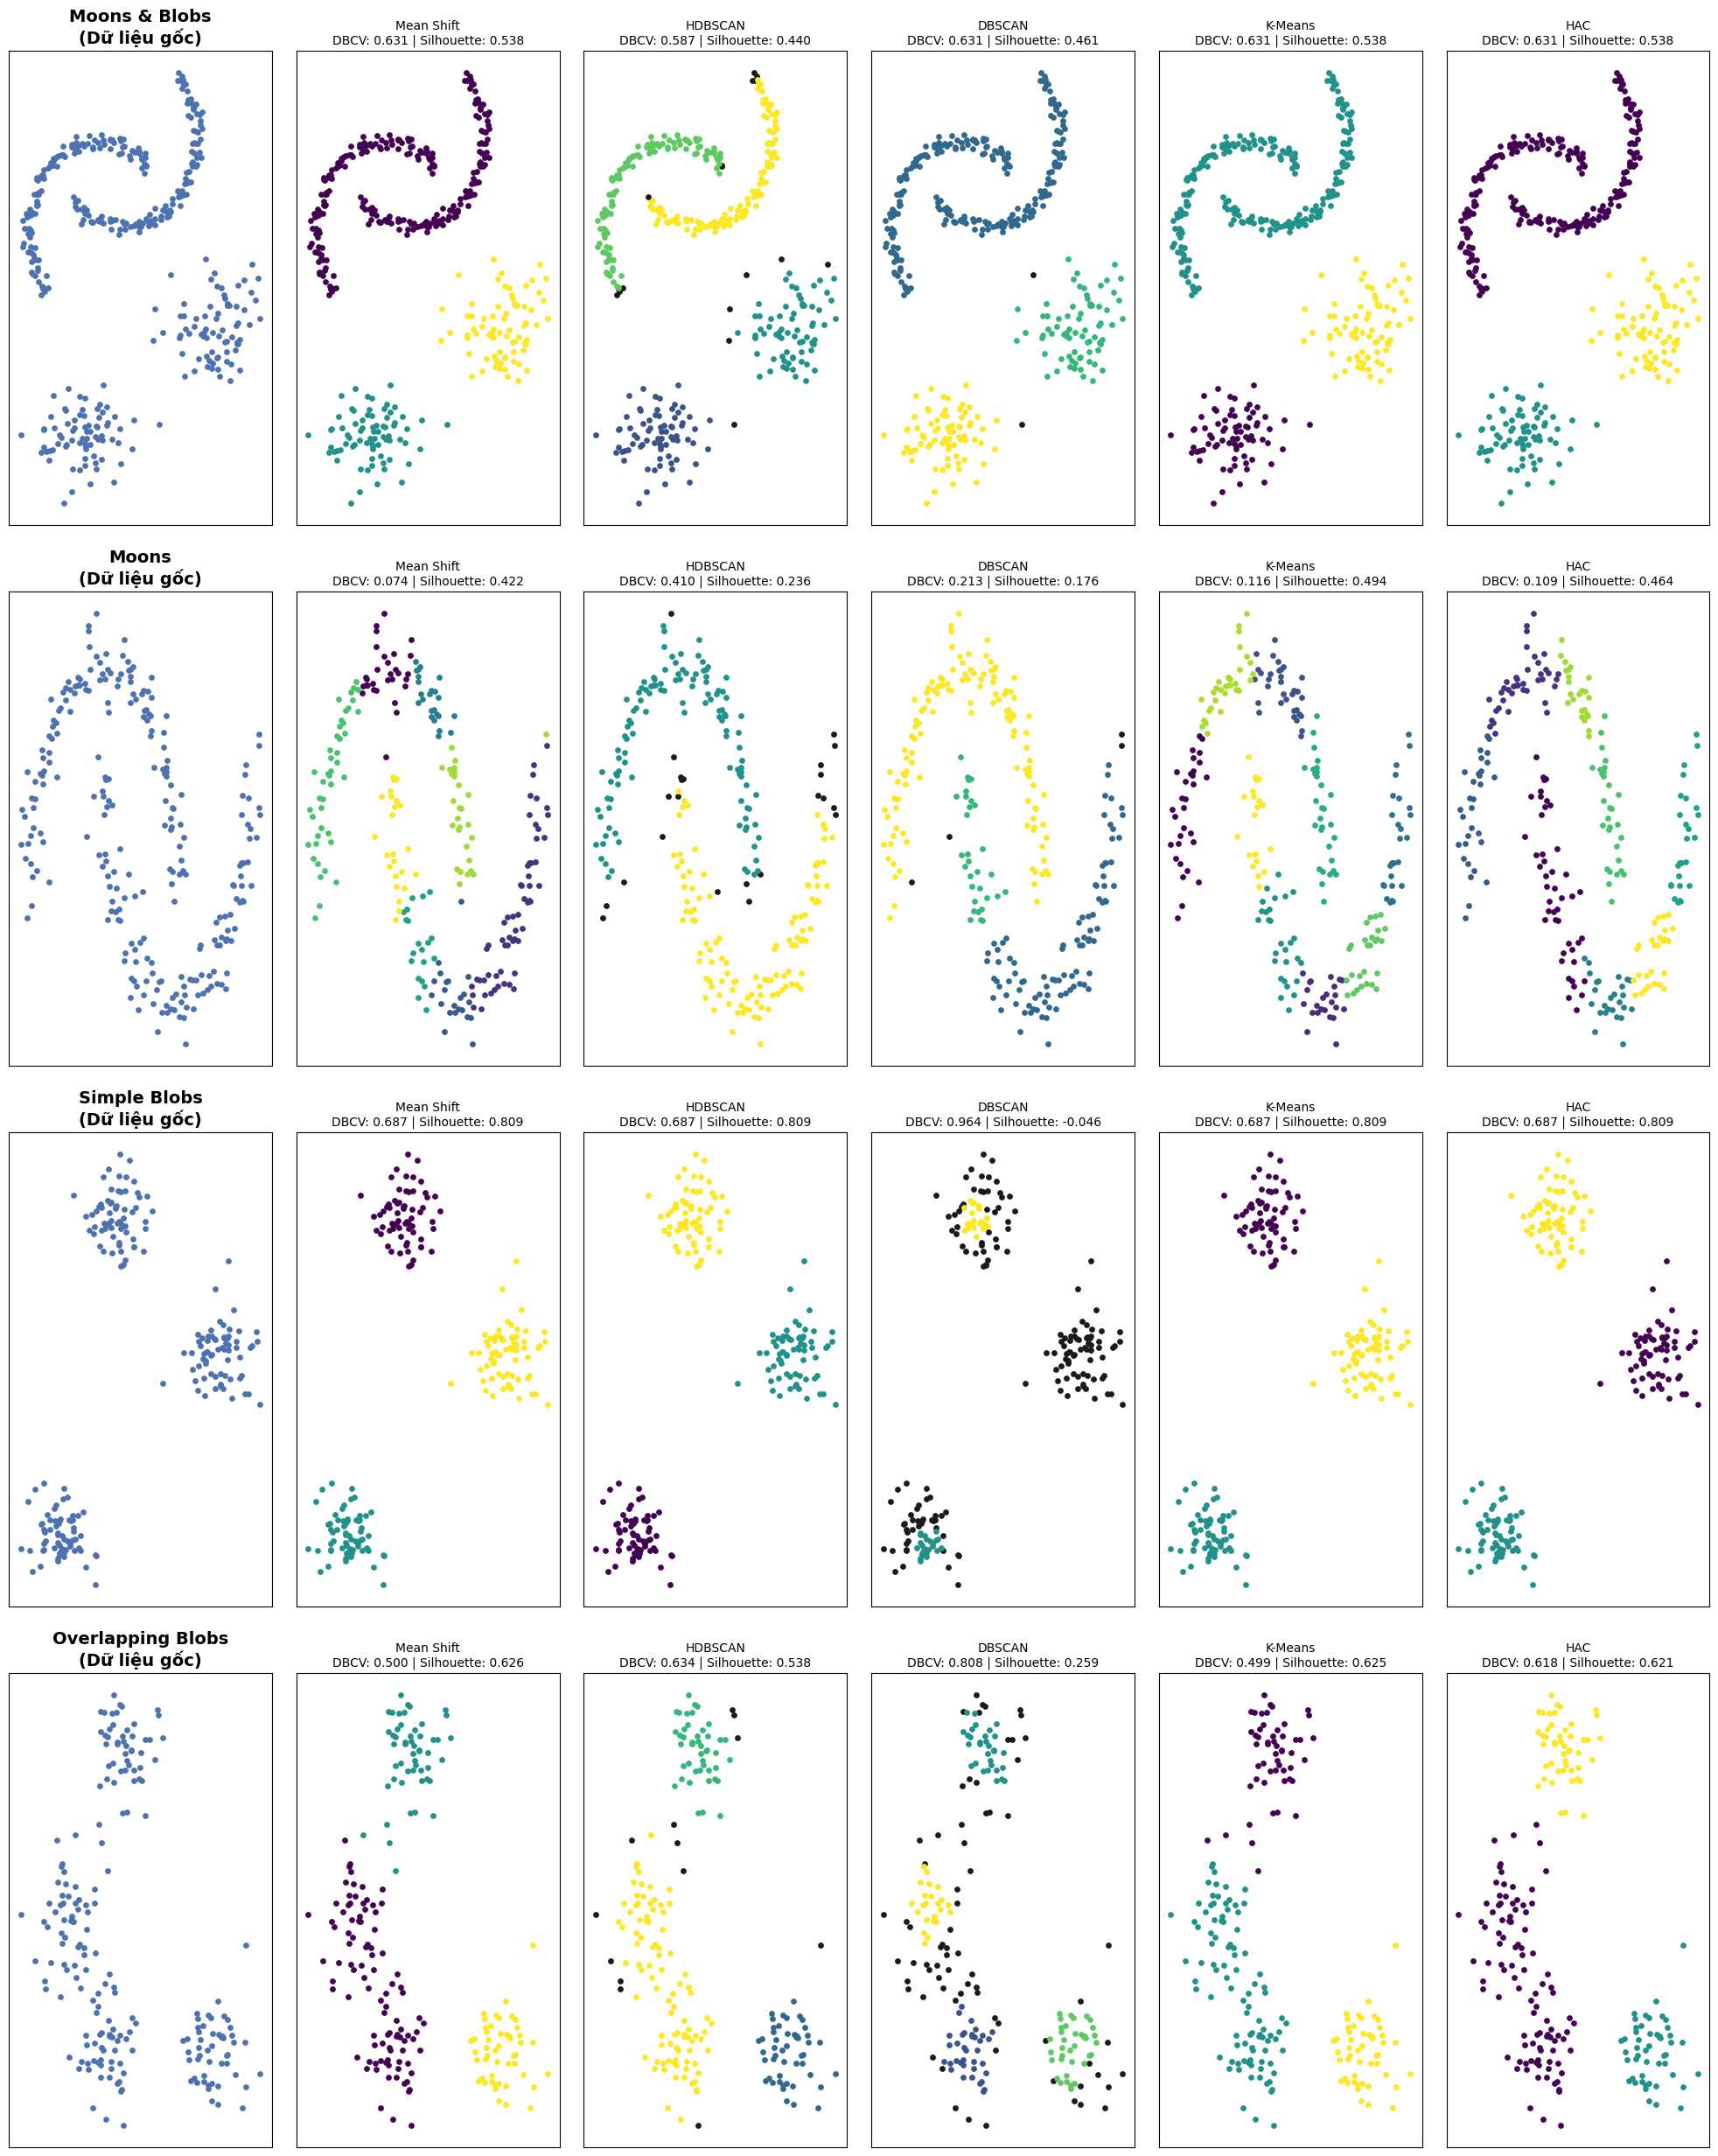

In [59]:
N_TRIALS = 30
datasets = {
    "Moons & Blobs": test_data,
    "Moons": test_data2,
    "Simple Blobs": blobs_2,
    "Overlapping Blobs": blobs_3
}

models_to_optimize = {
    "Mean Shift": objective_meanshift,
    "HDBSCAN": objective_hdbscan,
    'DBSCAN': opjective_dbscan,
    'K-Means': objective_kmeans,
    'HAC': objective_hac
}

results = {}

for name, data_scaled in datasets.items():
    print(f"\nĐang xử lý bộ dữ liệu: {name}")
    results[name] = {}
    for model_name, objective_func in models_to_optimize.items():
        print(f"Tối ưu hóa {model_name} ")
        
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective_func(trial, data_scaled), n_trials=N_TRIALS, show_progress_bar=False)
        
        best_params = study.best_params
        best_dbcv = study.best_value
        best_silhouette = study.best_trial.user_attrs.get("silhouette", "N/A")
        
        # Chạy lại mô hình với tham số tốt nhất để lấy nhãn
        if model_name == "Mean Shift":
            model = MeanShift(**best_params)
        elif model_name == "HDBSCAN":
            model = hdbscan.HDBSCAN(**best_params)
        elif model_name == "DBSCAN":
            model = DBSCAN(**best_params)
        elif model_name == "K-Means":
            model = KMeans(n_init=10, random_state=42, **best_params)
        elif model_name == "HAC":
            model = AgglomerativeClustering(**best_params)
            
        labels = model.fit_predict(data_scaled)
        
        results[name][model_name] = {
            "params": best_params,
            "labels": labels,
            "dbcv": best_dbcv,
            "silhouette": best_silhouette
        }
        print(f"{model_name} hoàn thành. Best DBCV: {best_dbcv:.4f}, Silhouette: {best_silhouette:.4f}")


fig, axes = plt.subplots(len(datasets), len(models_to_optimize) + 1, figsize=(20, 25))
plt.style.use('default')

for i, (data_name, data_scaled) in enumerate(datasets.items()):
    data_original = datasets[data_name]
    
    # Cột 1: Dữ liệu gốc
    ax = axes[i][0]
    ax.scatter(data_original[:, 0], data_original[:, 1], s=15, color='b')
    ax.set_title(f"{data_name}\n(Dữ liệu gốc)", fontsize=14, weight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Các cột còn lại: Kết quả của các thuật toán
    for j, model_name in enumerate(models_to_optimize.keys()):
        ax = axes[i][j+1]
        res = results[data_name][model_name]
        labels = res['labels']
        
        # Xử lý màu sắc
        unique_labels = set(labels)
        cmap = plt.colormaps.get('viridis') 
        colors = cmap(np.linspace(0, 1, len(unique_labels)))
        
        # Vẽ các điểm đã được phân cụm
        for k, col in zip(sorted(list(unique_labels)), colors):
            if k == -1:
                col = 'k'
            
            class_member_mask = (labels == k)
            xy = data_original[class_member_mask]
            ax.scatter(xy[:, 0], xy[:, 1], s=15, c=[col], label=f'Cluster {k}')
        
        dbcv_score = res['dbcv']
        sil_score = res['silhouette']
        
        best_params = res['params']
        
        params_str_parts = []
        for key, value in best_params.items():
            if isinstance(value, float):
                # Làm tròn số float để hiển thị ngắn gọn
                params_str_parts.append(f"{key}={value:.2f}")
            else:
                params_str_parts.append(f"{key}={value}")
        params_str = ", ".join(params_str_parts)

        title_str = (
            f"{model_name}\n"
            f"DBCV: {dbcv_score:.3f} | Silhouette: {sil_score:.3f}"
            #f"Params: {params_str}"
        )
        
        # Giảm cỡ chữ một chút để vừa vặn hơn
        ax.set_title(title_str, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(pad=2.0)
plt.show()

In [63]:
rows = []
for data_name, model_dict in results.items():
    for model_name, res in model_dict.items():
        dbcv = res.get('dbcv', None)
        sil = res.get('silhouette', None)
        params = res.get('params', {})
        
        # Tạo chuỗi param đã tối ưu
        param_str = ", ".join([
            f"{k}={v:.2f}" if isinstance(v, float) else f"{k}={v}"
            for k, v in params.items()
        ])
        
        rows.append({
            "Dataset": data_name,
            "Model": model_name,
            "DBCV": round(dbcv, 3) if dbcv is not None else None,
            "Silhouette": round(sil, 3) if sil is not None else None,
            "Params": param_str
        })

df_summary = pd.DataFrame(rows)
df_summary = df_summary.sort_values(["Dataset", "Model"]).reset_index(drop=True)

pd.set_option('display.max_colwidth', 120)
# Tạo cột xếp hạng DBCV cho mỗi bộ dữ liệu
df_summary

,Dataset,Model,DBCV,Silhouette,Params
0,Moons,DBSCAN,0.213,0.176,"eps=0.21, min_samples=4, metric=manhattan"
1,Moons,HAC,0.109,0.464,"n_clusters=8, linkage=ward"
2,Moons,HDBSCAN,0.410,0.236,"min_cluster_size=18, min_samples=17"
3,Moons,K-Means,0.116,0.494,n_clusters=9
4,Moons,Mean Shift,0.074,0.422,bandwidth=0.45
5,Moons & Blobs,DBSCAN,0.631,0.461,"eps=1.78, min_samples=19, metric=euclidean"
6,Moons & Blobs,HAC,0.631,0.538,"n_clusters=3, linkage=complete, metric=euclidean"
7,Moons & Blobs,HDBSCAN,0.587,0.440,"min_cluster_size=20, min_samples=20"
8,Moons & Blobs,K-Means,0.631,0.538,n_clusters=3
9,Moons & Blobs,Mean Shift,0.631,0.538,bandwidth=3.06


In [64]:
# Thuật tốt nhất dựa trên DBCV cho mỗi bộ dữ liệu
df_summary.loc[df_summary.groupby('Dataset')['DBCV'].transform('max') == df_summary['DBCV']]

,Dataset,Model,DBCV,Silhouette,Params
2,Moons,HDBSCAN,0.410,0.236,"min_cluster_size=18, min_samples=17"
5,Moons & Blobs,DBSCAN,0.631,0.461,"eps=1.78, min_samples=19, metric=euclidean"
6,Moons & Blobs,HAC,0.631,0.538,"n_clusters=3, linkage=complete, metric=euclidean"
8,Moons & Blobs,K-Means,0.631,0.538,n_clusters=3
9,Moons & Blobs,Mean Shift,0.631,0.538,bandwidth=3.06
10,Overlapping Blobs,DBSCAN,0.808,0.259,"eps=1.36, min_samples=10, metric=manhattan"
15,Simple Blobs,DBSCAN,0.964,-0.046,"eps=0.94, min_samples=14, metric=manhattan"


In [65]:
# Thuật tốt nhất dựa trên Silhouette cho mỗi bộ dữ liệu
df_summary.loc[df_summary.groupby('Dataset')['Silhouette'].transform('max') == df_summary['Silhouette']]

,Dataset,Model,DBCV,Silhouette,Params
3,Moons,K-Means,0.116,0.494,n_clusters=9
6,Moons & Blobs,HAC,0.631,0.538,"n_clusters=3, linkage=complete, metric=euclidean"
8,Moons & Blobs,K-Means,0.631,0.538,n_clusters=3
9,Moons & Blobs,Mean Shift,0.631,0.538,bandwidth=3.06
14,Overlapping Blobs,Mean Shift,0.500,0.626,bandwidth=4.70
16,Simple Blobs,HAC,0.687,0.809,"n_clusters=3, linkage=single, metric=euclidean"
17,Simple Blobs,HDBSCAN,0.687,0.809,"min_cluster_size=6, min_samples=3"
18,Simple Blobs,K-Means,0.687,0.809,n_clusters=3
19,Simple Blobs,Mean Shift,0.687,0.809,bandwidth=3.35


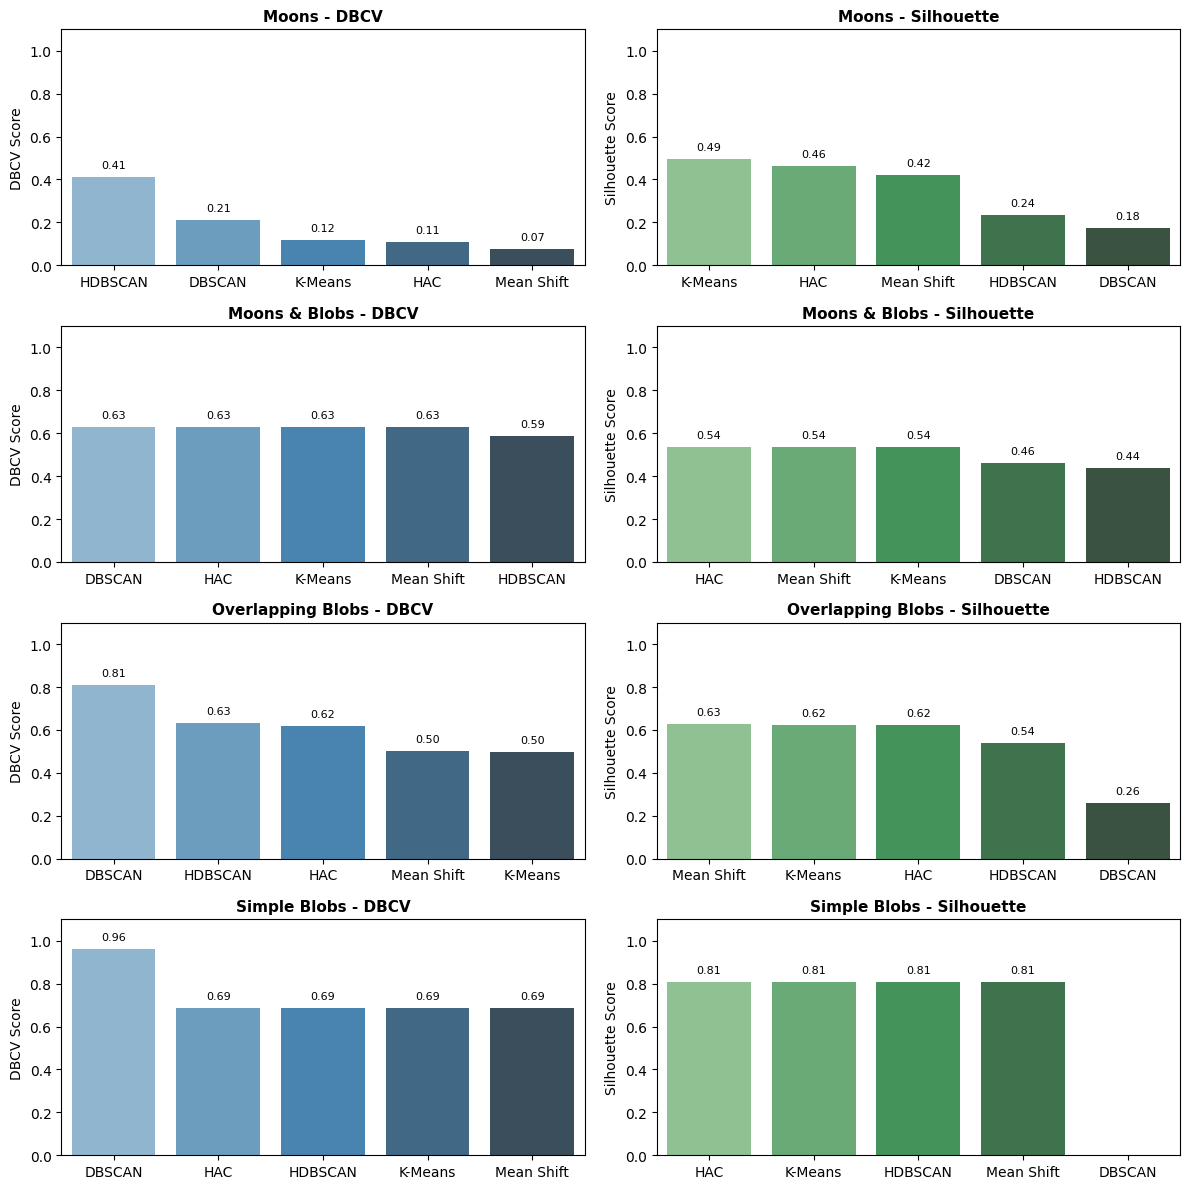

In [77]:
datasets = df_summary['Dataset'].unique()

# Tạo figure với 2 cột (DBCV / Silhouette) và mỗi dataset là 1 hàng
fig, axes = plt.subplots(len(datasets), 2, figsize=(12, 3 * len(datasets)))
plt.style.use('default')

for i, dataset in enumerate(datasets):
    subset = df_summary[df_summary['Dataset'] == dataset].copy()
    
    # Sắp xếp giảm dần
    subset_dbcv = subset.sort_values('DBCV', ascending=False)
    subset_sil = subset.sort_values('Silhouette', ascending=False)

    # Biểu đồ DBCV 
    sns.barplot(data=subset_dbcv, x='Model', y='DBCV', ax=axes[i, 0], palette='Blues_d')
    axes[i, 0].set_title(f"{dataset} - DBCV", fontsize=11, weight='bold')
    axes[i, 0].set_ylim(0, 1.1)
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel('DBCV Score')
    for p in axes[i, 0].patches:
        height = p.get_height()
        offset = 5 if height >= 0 else -10   # điều chỉnh hướng text tùy dấu
        va = 'bottom' if height >= 0 else 'top'
        axes[i, 0].annotate(f"{height:.2f}",
                            (p.get_x() + p.get_width()/2., height),
                            ha='center', va='bottom', fontsize=8,
                            xytext=(0, offset), textcoords='offset points')

    # Biểu đồ Silhouette 
    sns.barplot(data=subset_sil, x='Model', y='Silhouette', ax=axes[i, 1], palette='Greens_d')
    axes[i, 1].set_title(f"{dataset} - Silhouette", fontsize=11, weight='bold')
    axes[i, 1].set_ylim(0, 1.1)
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('Silhouette Score')
    for p in axes[i, 1].patches:
        height = p.get_height()
        offset = 5 if height >= 0 else -10
        va = 'bottom' if height >= 0 else 'top'
        axes[i, 1].annotate(f"{height:.2f}",
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va=va, fontsize=8,
                            xytext=(0, offset), textcoords='offset points')

plt.tight_layout(h_pad=1.2, w_pad=1.5)
plt.show()
